# OPManalysis - Example of OPM Data Analysis

This notebook demonstrates how to:

- Load experimental **Optically Pumped Magnetometers(OPMs)** data
- Extract one complete magnetic field sweep cycle
- Fit the demodulated signal using Lorentzian, Gaussian, or linear models for different analysis purposes
- Analyze noise using power spectral density (PSD)
- The demonstration dataset was acquired using **Moku:Pro (Liquid Instruments)**


If the package is not installed yet, install it with:

In [ ]:
pip install -e

## Introduction to Experimental Setup

<img src="images/fig1.png" alt="Setup" width="400"/>

This schematic shows the experimental configuration for OPM signal acquisition.  
The red beam (pump laser) propagates along the x-axis, while the modulated magnetic field is applied along the z-axis.

A modulation signal (from Moku:Pro LIA mode) and a triangular ramp function (from Moku:Pro FG mode) are combined via a bias tee and sent to the internal z-coil inside the magnetic shielding.  
The triangular ramp sweeps the background magnetic field, enabling field-resolved signal measurements.

We record two signals:
- The raw signal from the photodetector (absorption)
- The demodulated signal from the lock-in amplifier (dispersion)

These two signals are essential for accurate data analysis.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from opmanalysis import (
    lorentz_fit, gauss_fit, dispersion_lorentz_fit, linear_region_fit,
    one_cycle_cut, noise_psd
)

## Data Import and Processing

We use a demo dataset from an OPM experiment recorded by **Moku:Pro**.  
📂 The raw `.csv` files are located in `examples/Demo_data`, intended for testing and demonstration.

This dataset includes:
- **Absorption signal (`Ab`)**: raw signal measured by the photodetector
- **Demodulated signal (`demod`)**: processed signal from Moku:Pro lock-in amplifier (LIA)
- **Sampling time (`t`)**: recorded time axis

The signal was acquired under a **triangle-wave magnetic field modulation**  
with a sweep amplitude of **±34 nT** and a frequency of **0.5 Hz**.

---

Since the raw data may contain multiple cycles of the sweep,  
we isolate a **single complete sweep cycle** using the function `one_cycle_cut`.

This function automatically identifies and extracts one full triangle ramp sweep,  
centered around the absorption peak, and converts the time axis to magnetic field values.

---

### `one_cycle_cut(df, sweepB, sweepf)`

**Parameters:**

- `data` (DataFrame or ndarray):  
  Input data with columns `[time, Ab, demod]` or `[t, Ab, demod]`

- `sweepB` (float):  
  Amplitude of triangle wave modulation (e.g., in nT)

- `sweepf` (float):  
  Frequency of triangle wave (in Hz)

**Returns:**

- `BField` (ndarray):  
  Converted magnetic field axis, centered at the absorption peak

- `AbCut` (ndarray):  
  Cropped absorption signal

- `DemodCut` (ndarray):  
  Cropped demodulated signal

📌 **Note:** Input data must contain both `Ab` and `demod`.  
The function uses the absorption peak as a reference point. Missing either signal may lead to failure or incorrect output.


In [3]:
# === Data import ===

# Automatically detect the current notebook folder
thisdir = os.path.dirname(__file__) if '__file__' in globals() else os.getcwd()

# Relative path to the demo data folder
folder = os.path.join(thisdir, "Demo_data")

# 📌 If you're using your own data, modify the path like this:
# folder = r"C:\Users\YourName\Path\To\Your\Own\Data"

# Recursively search for all .csv files
all_csv_files = glob.glob(os.path.join(folder, "**", "*.csv"), recursive=True)

# Automatically classify data and noise files
data_files  = [f for f in all_csv_files if "noise" not in f.lower()]
noise_files = [f for f in all_csv_files if "noise" in f.lower()]

# Load the first matched pair
FILE      = data_files[0]
noiseFILE = noise_files[0]

# Read in data
df        = pd.read_csv(FILE, skiprows=10, names=['t','Ab','demod'])
noisedata = pd.read_csv(noiseFILE, skiprows=10, names=['t','signal1','signal2'])

# Confirm loaded file paths
print("✅ Loaded signal file:", FILE)
print("✅ Loaded noise file:",  noiseFILE)

✅ Loaded signal file: C:\Users\YiHsuanChen\OneDrive\桌面\Research\code\OPM_code\OPMpy\OPManalysis\examples\Demo_data\MokuLockInAmplifierData_20250619_150732_Traces.csv
✅ Loaded noise file: C:\Users\YiHsuanChen\OneDrive\桌面\Research\code\OPM_code\OPMpy\OPManalysis\examples\Demo_data\noise\MokuLockInAmplifierData_20250619_150805_Traces.csv


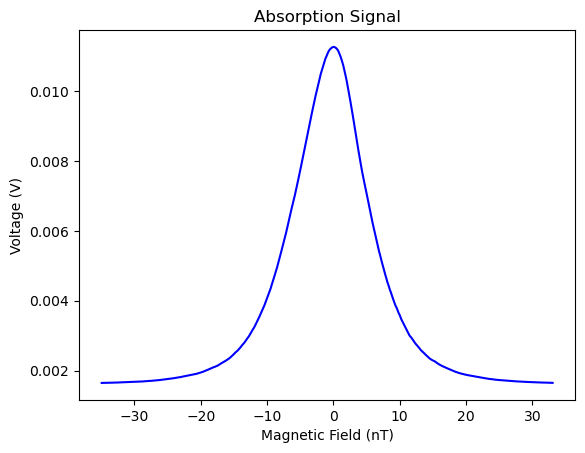

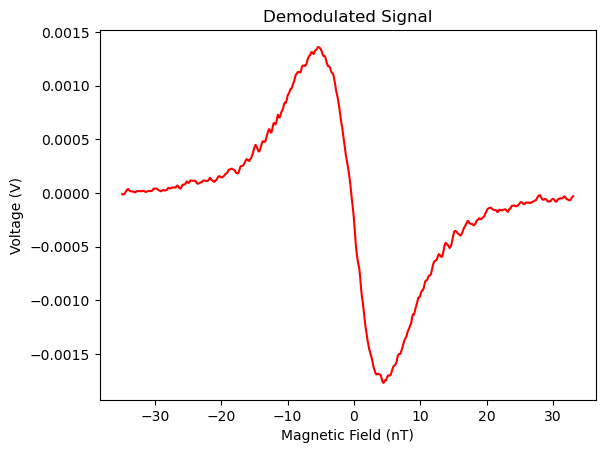

In [24]:
#Data processing
B, AbCut, DemodCut = one_cycle_cut(df, sweepB=34, sweepf=0.5)
data_demod = np.column_stack((B, DemodCut))
data_ab = np.column_stack((B, AbCut))
#Plot figures of single cycle
# --- Absorption signal ---
plt.figure()
plt.plot(data_ab[:, 0], data_ab[:, 1], 'b')
plt.title("Absorption Signal")
plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Voltage (V)")

# --- Demodulated signal ---
plt.figure()
plt.plot(data_demod[:, 0], data_demod[:, 1], 'r')
plt.title("Demodulated Signal")
plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Voltage (V)")

plt.show()

## Absorption Signal Fitting: Gaussian and Lorentz Models

In OPMs, the magnetic resonance linewidth is a key parameter to evaluate system performance.  
In this section, we fit the absorption signal using both Lorentzian and Gaussian models to extract the full width at half maximum (FWHM).

Two models are used:

- `lorentz_fit(data, p0=(a, b, c))`: typically suitable when **homogeneous broadening** dominates  
- `gauss_fit(data)`: more appropriate when **inhomogeneous broadening** is significant

The absorption signal (`AbCut`) is plotted and fitted with both models for comparison.  
Each fit returns the full width at half maximum (FWHM) and the coefficient of determination (R²), providing insight into resonance quality.

---

### Mathematical Models Used

- **Lorentzian**  
  $$
  f(B) = a\frac{1}{1 + (bB)^2} + c
  $$

- **Gaussian**  
  $$
  f(B) = a \exp\left( -\frac{(B - \mu)^2}{2\sigma^2} \right) + c
  $$

Lorentzian Fit — FWHM: 12.12 nT, R²: 0.9948
Gaussian Fit — FWHM: 13.13 nT, R²: 0.9936


C:\Users\YiHsuanChen\anaconda3\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


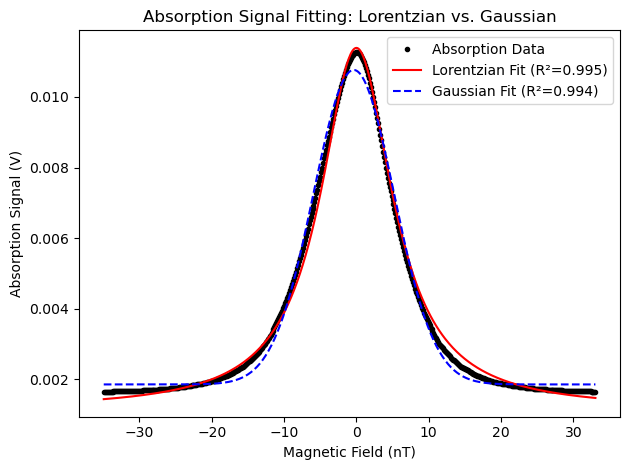

In [23]:
# === Lorentzian Fit ===
lorentz_result = lorentz_fit(data_ab, p0=(0.01, 0.01, 0.002))
print(f"Lorentzian Fit — FWHM: {lorentz_result['FWHM']:.2f} nT, R²: {lorentz_result['R2']:.4f}")

# === Gaussian Fit ===
gauss_result = gauss_fit(data_ab)
print(f"Gaussian Fit — FWHM: {gauss_result['FWHM']:.2f} nT, R²: {gauss_result['R2']:.4f}")

# === Plot ===
plt.figure()
plt.plot(data_ab[:,0], data_ab[:,1], 'k.', label='Absorption Data')
plt.plot(data_ab[:,0], lorentz_result['Data']['S_fit'], 'r-', label=f'Lorentzian Fit (R²={lorentz_result["R2"]:.3f})')
plt.plot(data_ab[:,0], gauss_result['Data']['S_fit'], 'b--', label=f'Gaussian Fit (R²={gauss_result["R2"]:.3f})')
plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Absorption Signal (V)")
plt.title("Absorption Signal Fitting: Lorentzian vs. Gaussian")
plt.legend()
plt.tight_layout()
plt.show()

## Dispersion Signal Fitting and Linear Region Detection

In low-field optically pumped magnetometers (OPMs), the demodulated signal often exhibits a dispersion-like shape.  
This behavior can be analytically approximated under the spin-exchange relaxation-free (SERF) regime.

We provide two analysis tools:

---

### 1. Automatic Linear Region Detection

In certain experimental regimes, the central region of the demodulated (dispersion-shaped) signal exhibits nearly linear behavior.  
This occurs especially under weak magnetic fields where the system is dominated by spin relaxation effects.  
The linear slope in this region is often used for **magnetic sensitivity estimation** or **field calibration**.

We apply a **sliding window algorithm** to automatically detect the most linear portion of the signal based on a coefficient of determination threshold ($R^2$):

- `linear_region_fit(data, win=10, r2min=0.95)`

The algorithm first identifies the region with the **maximum absolute slope** using a fixed-size window (`win`),  
then iteratively expands the region to include more points as long as the fitted line retains $R^2$ above the specified threshold (`r2min`).

It returns:

- The subset of data points within the detected linear region
- The slope and $R^2$ of the best-fit line
- A callable function for evaluating the linear fit


Linear Fit R² = 0.9901
Slope = -0.5280 mV/nT
Region is from -0.94 to 2.70 nT


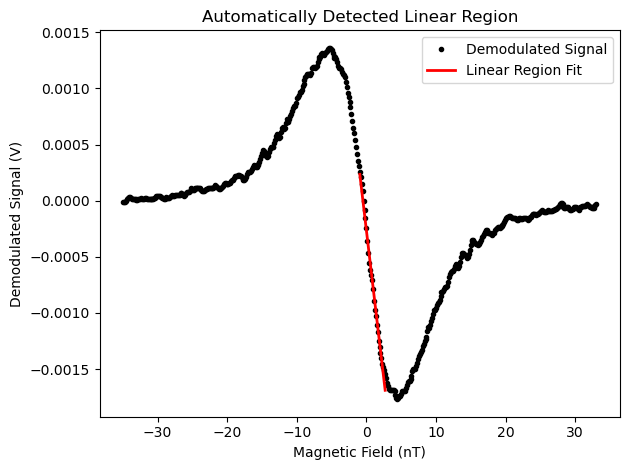

In [33]:
# Detect and fit the most linear region
lin_result = linear_region_fit(data_demod, r2min=0.99)

print("Linear Fit R² =", f"{lin_result['R2']:.4f}")
print("Slope =", f"{lin_result['Slope']*1e3:.4f}", "mV/nT")
print("Region is from", f"{min(lin_result['Region']['B']):.2f}", "to", f"{max(lin_result['Region']['B']):.2f}", "nT")

plt.figure()
plt.plot(B, DemodCut, 'k.', label='Demodulated Signal')
plt.plot(
    lin_result['Region']['B'],
    lin_result['FitResult'](lin_result['Region']['B']),
    'r-', linewidth=2,
    label='Linear Region Fit'
)
plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Demodulated Signal (V)")
plt.title("Automatically Detected Linear Region")
plt.legend()
plt.tight_layout()
plt.show()

Note: This method is purely data-driven and does not assume symmetry around zero field.  
While the estimated slope is often reasonably accurate,  
the selected region may slightly deviate from the physical center due to point-wise noise or asymmetry in sampling.

### 2. Dispersion Fit Using Analytical Model

We fit the demodulated signal (`demod`) using the following model:

$$
f(B) = A_0 \cdot \frac{\gamma B \tau}{1 + (\gamma B \tau)^2} + A_{\mathrm{offset}}
$$

where $\gamma$ is the gyromagnetic ratio and $\tau$ is the transverse relaxation time.

- `dispersion_lorentz_fit(data, p0, bounds)`  
  This model assumes the signal arises from atomic spin polarization under low magnetic fields.  
  It is **only valid near the center** (i.e., when the Lamour frequency $\omega_L = \gamma B \ll 1/\tau$).


Dispersion Fit R² = 0.8891


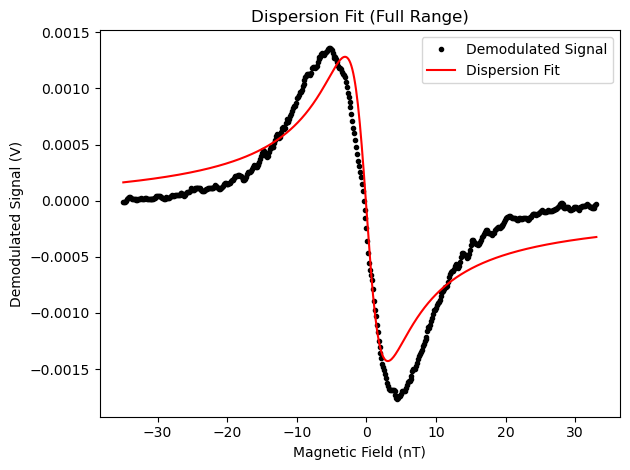

In [25]:
# Dispersion fit with full magnetic sweep range
disp_result = dispersion_lorentz_fit(data_demod)

print("Dispersion Fit R² =", f"{disp_result['R2']:.4f}")

plt.figure()
plt.plot(data_demod[:, 0], data_demod[:, 1], 'k.', label='Demodulated Signal')
plt.plot(data_demod[:, 0], disp_result['Data']['S_fit'], 'r-', label='Dispersion Fit')
plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Demodulated Signal (V)")
plt.title("Dispersion Fit (Full Range)")
plt.legend()
plt.tight_layout()
plt.show()

Note that fitting over the **entire sweep range** may lead to poor results.  
This is because the analytical dispersion model is only valid in the **low-field regime**,  
where the SERF condition ($\omega_L \ll 1/\tau$) holds.

To obtain reliable fit parameters, it is recommended to **limit the fitting to the low-field region**,  
as demonstrated in the next example.


Dispersion Fit R² = 0.9990


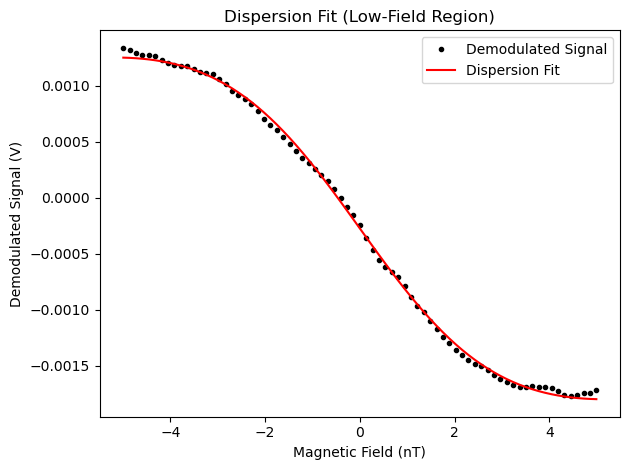

In [26]:
# Dispersion fit with low-field region only
mask = (data_demod[:,0] > -5) & (data_demod[:,0] < 5)
data_demod_focus = data_demod[mask]

disp_result_focus = dispersion_lorentz_fit(data_demod_focus)

print("Dispersion Fit R² =", f"{disp_result_focus['R2']:.4f}")

plt.figure()
plt.plot(data_demod_focus[:, 0], data_demod_focus[:, 1], 'k.', label='Demodulated Signal')
plt.plot(data_demod_focus[:, 0], disp_result_focus['Data']['S_fit'], 'r-', label='Dispersion Fit')
plt.xlabel("Magnetic Field (nT)")
plt.ylabel("Demodulated Signal (V)")
plt.title("Dispersion Fit (Low-Field Region)")
plt.legend()
plt.tight_layout()
plt.show()

#### Slope and Linear Range
With a successful fit of the demodulated signal using the analytical dispersion model,  
we can estimate both the **slope near zero field** and the **corresponding linear region**.

By performing a Taylor expansion of the analytical solution near \( B = 0 \),  
we obtain the first-order approximation:

$$
f(B) = A_0 \cdot \frac{\gamma B \tau}{1 + (\gamma B \tau)^2} + A_{\mathrm{offset}} 
\approx A_{\mathrm{offset}} + A_0 \gamma \tau B \left(1 - (\gamma\tau B)^2 + (\gamma\tau B)^4 - \cdots \right)
$$

This shows that the slope near $ B = 0 $ is approximately:

$$
\left.\frac{df}{dB}\right|_{B \approx 0} = A_0 \gamma \tau
$$

This linear approximation is valid only in the low-field regime.  
The leading source of nonlinearity is the second-order term $ (\gamma\tau B)^2 $,  
which grows rapidly outside the center.

---

In the `dispersion_lorentz_fit` function, we define a **recommended linear region**  
based on a relative error threshold of this term:

- By default, it ensures $ (\gamma \tau B)^2 < 0.01 $, i.e., **<1% nonlinearity**
- Users can adjust this threshold via the `max_rel_err` parameter

In [32]:
print("Slope =", f"{disp_result_focus['Slope']*1e3:.4f}", "mV/nT")
print("Region is from", f"{disp_result_focus['LinearRange'][1]:.2f}", "to", f"{disp_result_focus['LinearRange'][0]:.2f}", "nT")

Slope = -0.5901 mV/nT
Region is from -0.52 to 0.52 nT


This provides a **physically justified linear slope** and a **quantitative estimate** of the valid linear region.

## Noise Analysis: Power Spectral Density (PSD)

To evaluate the magnetic field sensitivity of the OPM system,  
we analyze the noise spectral density of the demodulated signal using a **power spectral density (PSD)** method.

We use the function `noise_psd(data, targetf, half_bw)` to compute:

- The PSD of the time-domain signal (column 3, assumed to be the demodulated LIA output)
- The **mean RMS noise spectral density** within a given frequency band

📌 **Note:** 

The noise data should be recorded with **no actual magnetic field applied**,  
meaning both **DC bias** and **triangle ramp modulation** should be disabled.  

However, the **lock-in amplifier's internal modulation** (reference signal) should still be active,  
since the demodulated signal is used for PSD analysis.  

Only the detection system should be active (e.g., light source, lock-in amplifier, photodetector),  
so that the measured spectrum reflects the **intrinsic electronic and optical noise** of the setup.
 

### Example Usage

In this example, we analyze the PSD around the modulation frequency of **100 Hz**,  
and compute the mean RMS noise over a ±2 Hz window (i.e., 98–102 Hz).

In [31]:
pts, rms, fs = noise_psd(noisedata, targetf=100, half_bw=2)

print(f"Sampling frequency = {fs} Hz")
print(f"RMS noise around 100 Hz = {rms*1e6:.2f} µV/√Hz")

Sampling frequency = 504 Hz
RMS noise around 100 Hz = 0.43 µV/√Hz


#### Visualization
The PSD is plotted to visualize noise distribution across frequency.
The shaded region indicates the integration band.

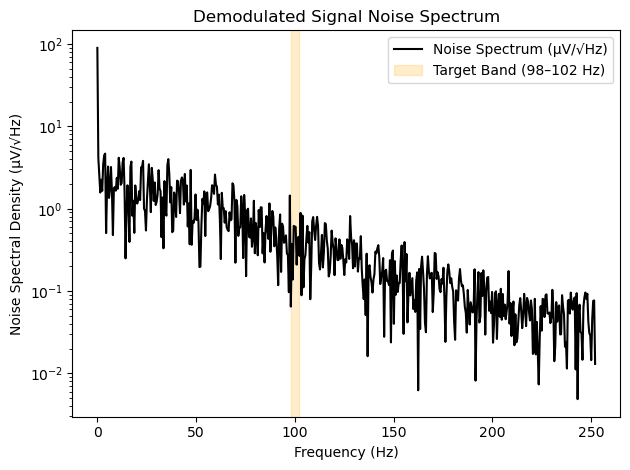

In [36]:
f, Pxx = pts[:, 0], pts[:, 1]

plt.figure()
plt.semilogy(f, np.sqrt(Pxx)*1e6, 'k-', label='Noise Spectrum (µV/√Hz)')
plt.axvspan(98, 102, color='orange', alpha=0.2, label='Target Band (98–102 Hz)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noise Spectral Density (µV/√Hz)")
plt.title("Demodulated Signal Noise Spectrum")
plt.legend()
plt.tight_layout()
plt.show()

📌 Note: A lower RMS value implies better sensitivity near the modulation frequency.

## Estimate Sensitivity of OPM System

The magnetic field sensitivity of an OPM system is commonly estimated as:

$$
\eta = \frac{V_{\mathrm{noise}}}{|\partial V / \partial B|} \quad \text{(in units of nT/√Hz)}
$$

where:

- $ V_{\mathrm{noise}} $: RMS noise spectral density at the modulation frequency (e.g., 100 Hz), in **V/√Hz**
- $ \partial V / \partial B $: Signal slope (i.e., voltage per unit magnetic field), in **V/nT**

---

### Step-by-Step Procedure

1. **Get signal slope near $ B = 0 $**  
   You may use:
   - `dispersion_lorentz_fit`: model-based slope $ A_0 \gamma \tau $
   - or `linear_region_fit`: data-driven slope over the linear region

2. **Get noise spectrum from a separate noise file**  
   Use `noise_psd(noise_data, targetf, half_bw)` to extract RMS value around your modulation frequency

3. **Estimate sensitivity**  
   Combine slope and noise to get:

In [39]:
slope = disp_result_focus['Slope']       # V/nT
_, rms, _ = noise_psd(noisedata, targetf=100, half_bw=2)  # V/√Hz

sensitivity = abs(rms / slope)*1e3                # pT/√Hz
print(f"Estimated sensitivity = {sensitivity:.3f} pT/√Hz")

Estimated sensitivity = 0.729 pT/√Hz


#### Remarks
This estimate represents the **best achievable sensitivity near DC**.

If the slope is obtained from a narrow linear region, it better represents the **central field sensitivity**.

If the system is limited by environmental or technical noise (e.g., optical or electronics), this analysis helps locate the bottleneck.
